In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
import numpy as np
import pandas as pd
from lmfit.models import GaussianModel, PolynomialModel
from lmfit import Parameter

In [159]:
def reset_redshift(dict, data):
    wavelength, flux, _, name = data
    lines = ['O3_5008', 'H_alpha']
    zs = []
    for line in lines:
        or_wave = dict['linelist_dict'][line]
        wave_O3 = dict['linelist_dict'][line] * (1 + dict['redshift'])
        mask = ((wavelength > wave_O3 - 150) &
                (wavelength < wave_O3 + 150))
        wave = wavelength[mask]
        fluxes = flux[mask]
        peak_index = np.argmax(fluxes)
        peak_wavelength = wave[peak_index]
        z = (peak_wavelength / or_wave) - 1
        zs.append(z)
    print(f'New calculated redshift for {name},  z = {np.median(zs)}')
    dict['redshift'] = np.median(zs)

In [160]:
reset_redshift(J0021, [J0021_['wave'].values, J0021_['flux'].values/1e-17, J0021_['noise'], 0])

New calculated redshift for 0,  z = 0.053106597326384564


In [28]:
def fit_auroral(wave1, flux1, dict, showplot=False, return_comps=False):
    stamps, comps = [], []
    path = '/Users/javieratoro/Desktop/proyecto 2024-2/lines/'
    params = pd.read_csv(path + f'J0243_model.csv')
    sigma_broad = 90 #np.median(params['sigma_v_broad'])
    sigma_narrow = 40 #np.median(params['sigma_v_narrow'])

    def get_center_and_sep(label):
        """Return the center and separation value based on the label."""
        center = dict['linelist_dict'][label] * (1 + dict['redshift'])
        center_N2 = dict['linelist_dict']['N2_6585'] * (1 + dict['redshift'])
        center_N1 = dict['linelist_dict']['N2_6550'] * (1 + dict['redshift'])
        sep = 2.5 * (center_N2 - center_N1)
        return center, sep

    auroral_lines = ['N2_5756', 'O1_6363',
                     'O3_4363', 'S3_6312',
                     'O2_7322']

    columns = ['sigma_v_narrow', 'sigma_v_broad']

    for label in auroral_lines:
        columns.append(str(label) + '_narrow_amplitude')
        columns.append(str(label) + '_broad_amplitude')

    columns.append('O2_7333_narrow_amplitude')
    columns.append('O2_7333_broad_amplitude')

    df = pd.DataFrame(columns=columns)
    row = {'sigma_v_narrow': sigma_narrow,
           'sigma_v_broad':sigma_broad}

    for label in auroral_lines:
        o2 = ['O2_7322', 'O2_7333']
        if label in o2:
            narrow_gaussians = []
            broad_gaussians = []
            for label in o2:
                center, sep = get_center_and_sep(label)

                mask = ( (wave1 < center+sep) & (wave1 > center-sep) )

                lamb = wave1[mask]
                flux2 = flux1[mask]

                for label_ in dict['linelist_dict'].keys():
                    center_, _ = get_center_and_sep(label_)
                    if center_ < center+sep or center_ > center-sep:
                        if label_ not in o2:
                            sep_ = 6
                            mask2 = ( (lamb < center_+sep_) & (lamb > center_-sep_) )
                            flux2[mask2] = np.nan

                # Narrow component
                narrow_gaussian = GaussianModel(prefix=label+'_narrow_')
                narrow_gaussians.append(narrow_gaussian)

                broad_gaussian = GaussianModel(prefix=label+'_broad_')
                broad_gaussians.append(broad_gaussian)

            polydeg = 1
            polynomial = PolynomialModel(degree=polydeg)

            sum_of_gaussians = broad_gaussians[0] + narrow_gaussians[0]
            for narrow, broad_value in zip(narrow_gaussians[1:],
                                            broad_gaussians[1:]):
                sum_of_gaussians += (broad_value + narrow)

            comp_mult = sum_of_gaussians + polynomial
            pars_mult = comp_mult.make_params()

            pars_mult.add(name='z', value=dict['redshift'], vary=False)

            pars_mult.add(name='sigma_v_narrow', value=sigma_narrow, vary=False)

            pars_mult.add(name='sigma_v_broad', value=sigma_broad, vary=False)

            for label in o2:
                lam = dict['linelist_dict'][label]
                for param in ['center', 'amplitude', 'sigma']:
                    narrow_key = f'{label}_narrow_{param}'
                    if param == 'center':
                        value = lam
                        vary = False
                        expr = f'{lam:6.2f}*(1+z)'
                    elif param == 'amplitude':
                        value = 1
                        vary = True
                        expr = None
                    elif param == 'sigma':
                        vary = False
                        expr = f'(sigma_v_narrow/3e5)*{label}_narrow_center'
                    pars_mult[narrow_key] = Parameter(name=narrow_key, value=value,
                                                        vary=vary, expr=expr,
                                                        min=0.0)

                    broad_key = f'{label}_broad_{param}'
                    if param == 'center':
                        value = lam
                        vary = False
                        expr = f'{lam:6.2f}*(1+z)'
                    elif param == 'amplitude':
                        value = 0.3
                        vary = True
                        expr = None
                    elif param == 'sigma':
                        vary = False
                        expr = f'(sigma_v_broad/3e5)*{label}_broad_center'
                    pars_mult[broad_key] = Parameter(name=broad_key,
                                                        value=value, min=0.0,
                                                        vary=vary, expr=expr)

            for i in range(polydeg+1):
                pars_mult[f'c{i:1.0f}'].set(value=0)

            fit = comp_mult.fit(flux2, pars_mult, x=lamb,
                                nan_policy='omit', max_nfev=1000)

            stamps.append([lamb, flux2])
            comps.append(fit)
            for label in o2:
                name1 = str(label) + "_narrow_amplitude"
                name2 = str(label) + "_broad_amplitude"
                row[name1] = float(fit.params[name1].value)
                row[name2] = float(fit.params[name2].value)


        else:
            center, sep = get_center_and_sep(label)

            mask = ( (wave1 < center+sep) & (wave1 > center-sep) )

            lamb = wave1[mask]
            flux2 = flux1[mask]


            for label_ in dict['linelist_dict'].keys():
                center_, _ = get_center_and_sep(label_)
                if center_ < center+sep or center_ > center-sep:
                    if label_ != label:
                        sep_ = 6
                        mask2 = ( (lamb < center_+sep_) & (lamb > center_-sep_) )
                        flux2[mask2] = np.nan

            narrow_gaussians = []
            broad_gaussians = []

            # Narrow component
            narrow_gaussian = GaussianModel(prefix=label+'_narrow_')
            narrow_gaussians.append(narrow_gaussian)

            broad_gaussian = GaussianModel(prefix=label+'_broad_')
            broad_gaussians.append(broad_gaussian)

            polydeg = 1
            polynomial = PolynomialModel(degree=polydeg)

            sum_of_gaussians = broad_gaussians[0] + narrow_gaussians[0]
            for narrow, broad_value in zip(narrow_gaussians[1:],
                                            broad_gaussians[1:]):
                sum_of_gaussians += (broad_value + narrow)

            comp_mult = sum_of_gaussians + polynomial
            pars_mult = comp_mult.make_params()

            pars_mult.add(name='z', value=dict['redshift'], vary=False)

            pars_mult.add(name='sigma_v_narrow', value=sigma_narrow, vary=False)

            pars_mult.add(name='sigma_v_broad', value=sigma_broad, vary=False)

            lam = dict['linelist_dict'][label]
            for param in ['center', 'amplitude', 'sigma']:
                narrow_key = f'{label}_narrow_{param}'
                if param == 'center':
                    value = lam
                    vary = False
                    expr = f'{lam:6.2f}*(1+z)'
                elif param == 'amplitude':
                    value = 1
                    vary = True
                    expr = None
                elif param == 'sigma':
                    vary = False
                    expr = f'(sigma_v_narrow/3e5)*{label}_narrow_center'
                pars_mult[narrow_key] = Parameter(name=narrow_key, value=value,
                                                    vary=vary, expr=expr,
                                                    min=0.0)

                broad_key = f'{label}_broad_{param}'
                if param == 'center':
                    value = lam
                    vary = False
                    expr = f'{lam:6.2f}*(1+z)'
                elif param == 'amplitude':
                    value = 0.3
                    vary = True
                    expr = None
                elif param == 'sigma':
                    vary = False
                    expr = f'(sigma_v_broad/3e5)*{label}_broad_center'
                pars_mult[broad_key] = Parameter(name=broad_key,
                                                    value=value, min=0.0,
                                                    vary=vary, expr=expr)

            for i in range(polydeg+1):
                pars_mult[f'c{i:1.0f}'].set(value=0)


            fit = comp_mult.fit(flux2, pars_mult, x=lamb,
                                            nan_policy='omit', max_nfev=1000)


            stamps.append([lamb, flux2])
            comps.append(fit)

            name1 = str(label) + "_narrow_amplitude"
            name2 = str(label) + "_broad_amplitude"
            row[name1] = float(fit.params[name1].value)
            row[name2] = float(fit.params[name2].value)

    df.loc[len(df)] = row

    if showplot is True:
        fig, axs = plt.subplots(3, 2, figsize=(10, 12))
        axs = axs.ravel()

        for idx, (stamp, label, fit) in enumerate(zip(stamps, auroral_lines, comps)):
            lamb, flux = stamp

            # print(fit.params)
            comp = fit.eval_components(x=lamb)
            best = fit.eval(x=lamb)
            axs[idx].set_title(label)
            axs[idx].plot(lamb, flux, 'red', lw=1, drawstyle='steps-mid',
                        label='Masked spectrum', alpha=0.5)
            axs[idx].plot(lamb, best, 'black', lw=1, alpha=0.5,
                        label='Best fit')
            axs[idx].plot(lamb, comp[f'{label}_narrow_'] + comp['polynomial'],
                        'teal', linestyle='--', lw=1, alpha=0.5, label='Narrow component')
            axs[idx].plot(lamb, comp[f'{label}_broad_'] + comp['polynomial'],
                        'blue', linestyle='--', lw=1, alpha=0.5, label='Broad component')
            if label in o2:
                axs[idx].plot(lamb, comp['O2_7333_narrow_'] + comp['polynomial'],
                        'teal', linestyle='--', lw=1, alpha=0.5, label='Narrow component')
                axs[idx].plot(lamb, comp[f'O2_7333_broad_'] + comp['polynomial'],
                        'blue', linestyle='--', lw=1, alpha=0.5, label='Broad component')

            axs[idx].set_xlabel(r'Obs. Wavelength ($\AA$)', size=14)
            axs[idx].set_ylabel(r'Flux ($10^{-17} erg/s/cm^{2}/\AA$)', size=14)
            axs[idx].set_xlim([np.min(lamb), np.max(lamb)])
            axs[idx].set_ylim([np.min(fit.best_fit) - 5,
                            np.max(fit.best_fit) + 5])
            axs[idx].legend()

        for ax in axs[len(stamps):]:
            ax.axis("off")

        fig.tight_layout()
        plt.show()
    return df


def fitSpectrumMC_auroral(dict, numMC=400):

    columns = ['sigma_v_narrow', 'sigma_v_broad']

    auroral_lines = ['N2_5756', 'O1_6363',
                     'O3_4363', 'S3_6312',
                     'O2_7322', 'O2_7333']

    for label in auroral_lines:
        name1 = str(label) + "_narrow_amplitude"
        name2 = str(label) + "_broad_amplitude"
        columns.append(name1)
        columns.append(name2)

    df = pd.DataFrame(columns=columns)

    wave, flux, noise, _ = dict['datas'][0]

    for i in range(numMC):
        # Create a data set with random offsets scaled by uncertainties

        yoff = flux + np.random.randn(len(flux)) * noise

        res = fit_auroral(wave, flux + yoff , dict)

        df = pd.concat([df, res], ignore_index=True)

    return df


def fit_MC_auroral(dict, numMC_=100):
    _, flux, _, _ = dict['datas'][0]

    info = fitSpectrumMC_auroral(dict, numMC=numMC_)

    df = pd.DataFrame(columns=['ID', 'mass', 'z', 'name', 'flux', 'fluxerr',
                                'narrow_flux', 'narrow_fluxerr',
                                'broad_flux', 'broad_fluxerr'])

    auroral_lines = ['N2_5756', 'O1_6363',
                     'O3_4363', 'S3_6312',
                     'O2_7322', 'O2_7333']

    for label in auroral_lines:  # Corrected loop variable
        narrow_ = np.asarray(info[label+"_narrow_amplitude"])
        broad_ = np.asarray(info[label+"_broad_amplitude"])
        flux = narrow_ + broad_
        row = {'ID': dict['names'][0],
                'mass': dict['mass'],
                'z': dict['redshift'],
                'name': label,
                'flux': np.mean(flux),
                'fluxerr': np.std(flux),
                'narrow_flux': np.mean(info[label+"_narrow_amplitude"]),
                'narrow_fluxerr': np.std(info[label+"_narrow_amplitude"]),
                'broad_flux': np.mean(info[label+"_broad_amplitude"]),
                'broad_fluxerr': np.std(info[label+"_broad_amplitude"])}
        df.loc[len(df)] = row

    narrow_1 = np.asarray(info['O2_7322_narrow_amplitude'])
    broad_1 = np.asarray(info["O2_7322_broad_amplitude"])
    narrow_2 = np.asarray(info["O2_7333_narrow_amplitude"])
    broad_2 = np.asarray(info["O2_7333_broad_amplitude"])
    flux = narrow_1 + broad_1 + narrow_2 + broad_2
    row = {'ID': dict['names'][0],
            'mass': dict['mass'],
            'z': dict['redshift'],
            'name': 'O2_7322_7333',
            'flux': np.mean(flux),
            'fluxerr': np.std(flux),
            'narrow_flux': np.mean(narrow_1 + narrow_2),
            'narrow_fluxerr': np.std(narrow_1 + narrow_2),
            'broad_flux': np.mean(broad_1 + broad_2),
            'broad_fluxerr': np.std(broad_1 + broad_2)}
    df.loc[len(df)] = row
    name = dict["names"][0][:5]
    df.to_csv(f'/Users/javieratoro/Desktop/proyecto 2024-2/lines/{name}_auroral.csv', index=False)
    info.to_csv(f'/Users/javieratoro/Desktop/proyecto 2024-2/lines/{name}_auroral_model.csv', index=False)
    return df

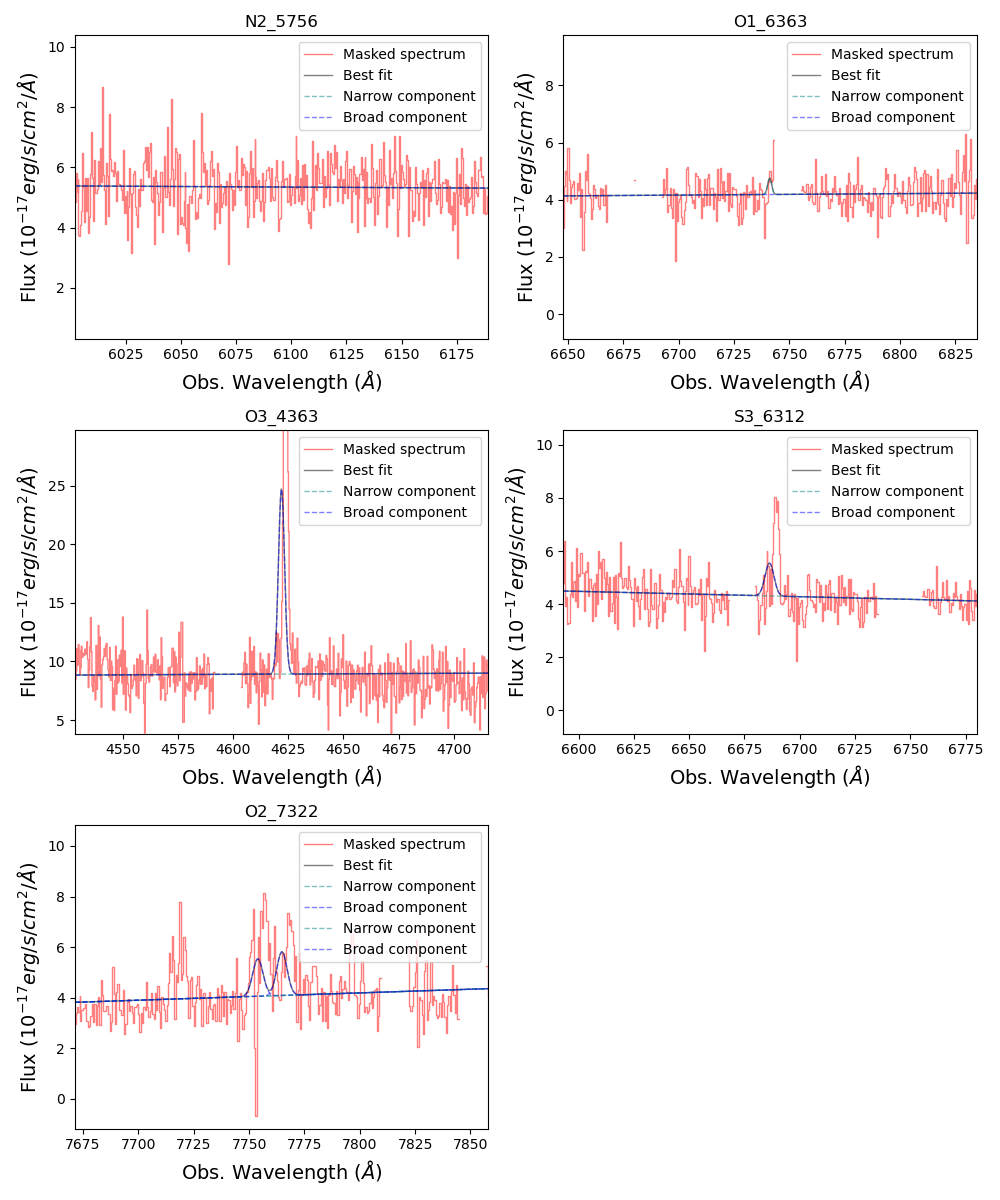

In [29]:
a = fit_auroral(J0021_['wave'], J0021_['flux']/1e-17, J0021, showplot=True)

In [165]:
fit_MC_auroral(J0021)

/var/folders/b3/z1vmt1t542ncmpppx7tfrqd80000gn/T/ipykernel_7207/2446858237.py:289: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, res], ignore_index=True)


,ID,mass,z,name,flux,fluxerr,narrow_flux,narrow_fluxerr,broad_flux,broad_fluxerr
0,J0136-0037,9.1,0.053107,N2_5756,1.090947,0.529491,3.558070e-07,0.000001,1.090946,0.529491
1,J0136-0037,9.1,0.053107,O1_6363,34.421877,0.741815,2.283996e+01,0.857632,11.581919,1.367898
2,J0136-0037,9.1,0.053107,O3_4363,125.184855,1.242471,7.722136e+01,1.430786,47.963493,1.920223
3,J0136-0037,9.1,0.053107,S3_6312,34.540245,0.624075,2.494395e+01,0.786582,9.596297,1.111886
4,J0136-0037,9.1,0.053107,O2_7322,58.898987,0.757490,2.901443e+01,0.888572,29.884558,1.443482
5,J0136-0037,9.1,0.053107,O2_7333,53.207271,1.140299,2.802015e+01,1.293152,25.187119,2.004879
6,J0136-0037,9.1,0.053107,O2_7322_7333,112.106258,1.395380,5.703458e+01,1.575579,55.071677,2.489267
